### Introduction
In this notebook, we create charts to explain Case 3 outlined in the "Why FIL+ makes Filecoin, Filecoin" document.
Case 3 states:
StorageRevenue > BlockRewards * (1-m) + (k-1) * CCSectorCost
==> NetworkSubsidy = (m-1) * BlockReward

Our approach is as follows:
1. Use reference data (Angelo's Spreadsheets) to get some point estimates of CCSectorCost and DealSectorCost. 
`k = DealSectorCost/CCSectorCost`. To account for additional costs that are not accounted for in the point estimate (such as BizDev), we scale up k.

2. Next, let us assume that StorageRevenue = 0. We make this assumption because:
    - This is the predominant state of deals on the network currently.
    - As an incentive mechanism, Fil+ 
    
3. Now, for several scenarios of BlockRewards (optimistic, status-quo, pessimistic), let us back calculate the required minimum multiplier to make the equation hold.

4. Perhaps a plot of StorageRevenue needed as we scale m would be a nice plot too.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
from datetime import date, timedelta
from tqdm.auto import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax.random import PRNGKey

import mechafil.data as mecha_data

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting
import mechafil_jax.plot_utils as pu
import mechafil_jax.date_utils as du

import scenario_generator.utils as u

from cel_utils import disk_utils

In [4]:
save_dir = os.path.join(os.environ['HOME'], 'Documents/filp_costs')
offline_info_dir = os.path.join(save_dir, 'offline_info')
os.makedirs(save_dir, exist_ok=True)
os.makedirs(offline_info_dir, exist_ok=True)

In [8]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'

current_date = date(2023,7,31) - timedelta(days=3)
start_date = date(current_date.year, current_date.month, 1)
forecast_length = 365*3
end_date = current_date + timedelta(days=forecast_length)

offline_data = data.get_simulation_data(token, start_date, current_date, end_date)

print(start_date, current_date, end_date)

2023-07-01 2023-07-28 2026-07-27


In [9]:
t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(current_date-timedelta(days=365*2), current_date)
t_hist_rr, hist_rr = u.get_historical_renewal_rate(current_date-timedelta(days=365*2), current_date)
t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(current_date-timedelta(days=365*2), current_date)
day_vec = np.arange(0,len(hist_fpr))

In [23]:
scenarios = ['pessimistic', 'status-quo', 'optimistic']
scenario_scalers = [0.5, 1.0, 1.5]

sector_duration = 365
lock_target = 0.3
rbp_base = np.median(hist_rbp[-30:])
rr_base = np.median(hist_rr[-30:])
fpr_base = np.median(hist_fpr[-30:])

scenario2results = {}
for ii, scenario_scaler in enumerate(scenario_scalers):    
    scenario = scenarios[ii]
    
    rbp = jnp.ones(forecast_length) * rbp_base * scenario_scaler
    rr = jnp.ones(forecast_length) * rr_base * scenario_scaler
    fpr = jnp.ones(forecast_length) * fpr_base
    
    simulation_results = sim.run_sim(
        rbp,
        rr,
        fpr,
        lock_target,
        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data
    )
    scenario2results[scenario] = simulation_results

<IPython.core.display.Javascript object>


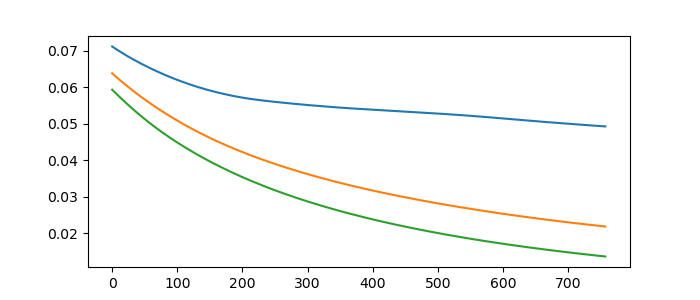

In [28]:
plt.figure(figsize=(7,3))

k = '1y_return_per_sector'
# k = '1y_sector_roi'
# k = 'day_pledge_per_QAP'
plt.plot(scenario2results['pessimistic'][k])
plt.plot(scenario2results['status-quo'][k])
plt.plot(scenario2results['optimistic'][k])

In [31]:
# index 0 is the return at the current time-snapshot, for each onboarding scenario
#  b/c pessimisitic onboarding corresponds to a shrinking network, there are more rewards/sector in this case
#  conversely for the other scenarios
k = '1y_return_per_sector'
pib_per_sector = C.PIB/C.SECTOR_SIZE
print(scenario2results['pessimistic'][k][0]*pib_per_sector, 
      scenario2results['status-quo'][k][0]*pib_per_sector, 
      scenario2results['optimistic'][k][0]*pib_per_sector)

2330.6252 2090.1113 1943.7156


In [64]:
usd_per_fil_vec = [3, 5, 10]
k_vec = [2, 4, 8]
CC_sector_costs_vec_usd = [.1, .5, 1.0]
storage_revenue_per_sector_usd_vec = [0, 1, 2]

results_list = []
for scenario in scenarios:
    return_per_sector = scenario2results[scenario]['1y_return_per_sector'][0]
    for usd_per_fil in usd_per_fil_vec:
        for CC_sector_cost_usd in CC_sector_costs_vec_usd:
            for k in k_vec:
                for storage_revenue_per_sector_usd in storage_revenue_per_sector_usd_vec:
                    return_per_sector_FIL = float(return_per_sector)
                    return_per_sector_USD = float(return_per_sector*usd_per_fil)
                    deal_sector_cost_usd = CC_sector_cost_usd * k
                    m_minimum = (deal_sector_cost_usd-storage_revenue_per_sector_usd) / return_per_sector_USD + 1

                    results_list.append({
                        'scenario': scenario,
                        'token_price': usd_per_fil,
                        'CC_sector_cost': CC_sector_cost_usd,
                        'k': k,
                        'return_per_sector_FIL':float(return_per_sector),
                        'return_per_sector_USD':float(return_per_sector*usd_per_fil),
                        'sector_revenue_per_sector_usd':float(storage_revenue_per_sector_usd),
                        'm_minimum': m_minimum,
                    })
                
df = pd.DataFrame(results_list)

In [65]:
df.dtypes

scenario                          object
token_price                        int64
CC_sector_cost                   float64
k                                  int64
return_per_sector_FIL            float64
return_per_sector_USD            float64
sector_revenue_per_sector_usd    float64
m_minimum                        float64
dtype: object

<IPython.core.display.Javascript object>


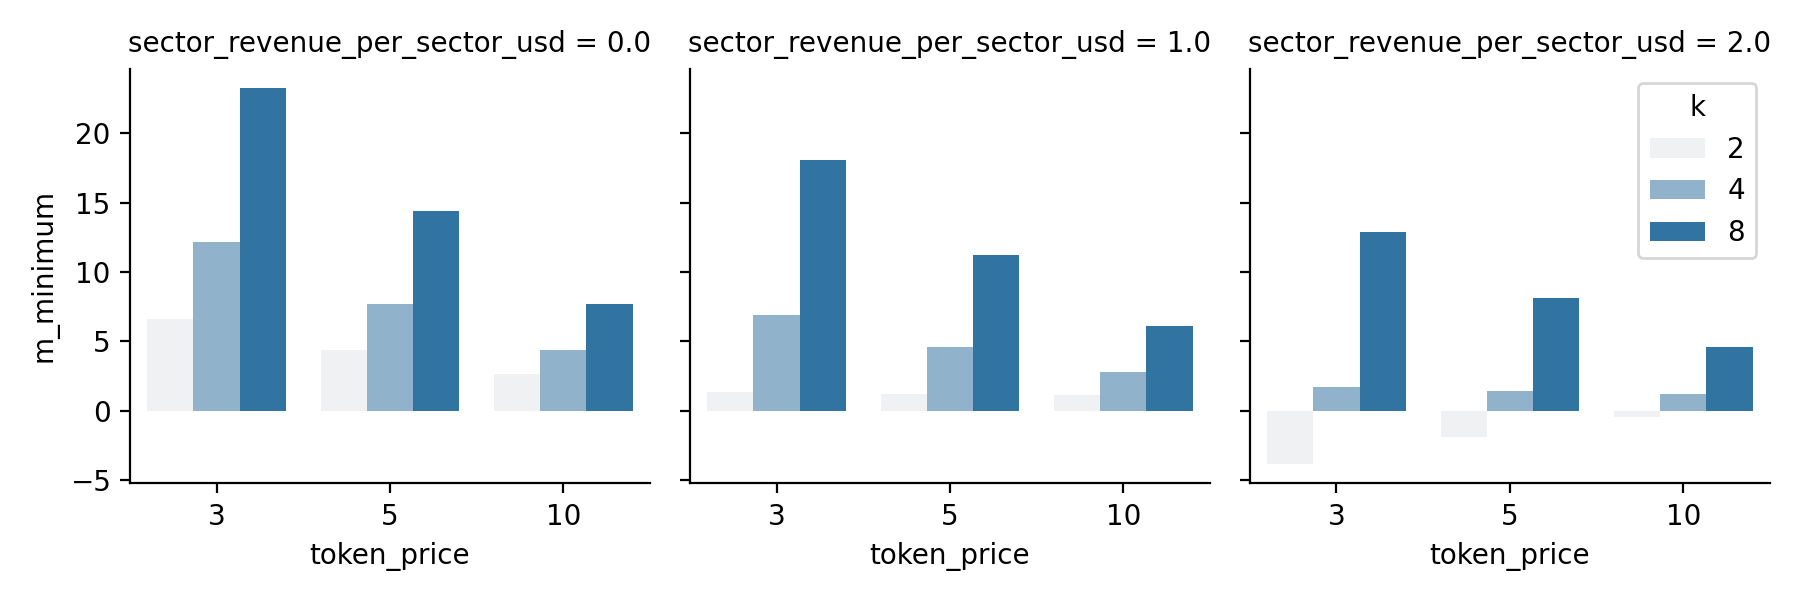

In [66]:
g = sns.FacetGrid(df[df['scenario']=='status-quo'], col='sector_revenue_per_sector_usd')
g.map_dataframe(sns.barplot, x='token_price', y='m_minimum', hue='k', errorbar=None)
plt.legend(title='k')